In [1]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# split dataset
import splitfolders
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
batch_size = 32
epochs = 50
LearningRate = 1e-3
Decay = 1e-6
img_width = 224
img_height = 224

In [3]:
CurrentDirectory = "./"
train_directory = CurrentDirectory + 'TRAIN/'
test_directory  = CurrentDirectory + 'TEST/'
model_directory = CurrentDirectory + 'MODEL/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [4]:
os.listdir('TRAIN')

['chichen_itza',
 '.DS_Store',
 'pyramids_of_giza',
 'roman_colosseum',
 'taj_mahal',
 'eiffel_tower',
 'stonehenge',
 'venezuela_angel_falls',
 'great_wall_of_china',
 'statue_of_liberty',
 'burj_khalifa',
 'machu_pichu',
 'christ_the_reedemer']

In [5]:
# ResnetModel = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
# x = GlobalAveragePooling2D()(ResnetModel.output)
# predictions = Dense(12, activation='softmax')(x)

# DeepLearning = Model(inputs=ResnetModel.input, outputs=predictions)
# DeepLearning.compile(optimizer=
#          SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
#          loss='categorical_crossentropy',
#          metrics=['acc']
# )

In [7]:
ResnetModel = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(ResnetModel.output)
predictions = Dense(12, activation='softmax')(x)

DeepLearning = Model(inputs=ResnetModel.input, outputs=predictions)
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
)

Metal device set to: Apple M1


2022-07-18 11:45:18.010478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-18 11:45:18.010572: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


9406464/9406464 [==============================] - 0s 0us/step


In [8]:
DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) 
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [9]:
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "validation")

TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode= "categorical")

Found 2769 images belonging to 12 classes.
Found 303 images belonging to 12 classes.
Found 393 images belonging to 12 classes.


In [10]:
Image, Label = TEST_GENERATOR.__getitem__(0) # [1]

In [10]:
# CP = ModelCheckpoint(filepath=model_directory+'ResNet50-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
#             monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)
# LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

# CALLBACK = [CP, TB, LR]

In [11]:
CP = ModelCheckpoint(filepath=model_directory+'MobileNetV2-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')
TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, TB, LR]

In [12]:
DeepLearning.fit(
        TRAIN_GENERATOR,
        steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        epochs=15,
        callbacks=CALLBACK,
        shuffle=True, 
        validation_data=VALID_GENERATOR)

Epoch 1/15


2022-07-18 11:45:46.620123: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-18 11:45:48.164047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


87/86 [==============================] - ETA: 0s - loss: 1.1625 - acc: 0.6475

2022-07-18 11:46:29.869164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.66337, saving model to ./MODEL/MobileNetV2-001-0.9963-0.6634.hdf5
86/86 [==============================] - 47s 499ms/step - loss: 1.1625 - acc: 0.6475 - val_loss: 0.9963 - val_acc: 0.6634 - lr: 0.0010
Epoch 2/15
87/86 [==============================] - ETA: 0s - loss: 0.3519 - acc: 0.9014
Epoch 2: val_acc improved from 0.66337 to 0.71617, saving model to ./MODEL/MobileNetV2-002-0.8926-0.7162.hdf5
86/86 [==============================] - 43s 489ms/step - loss: 0.3519 - acc: 0.9014 - val_loss: 0.8926 - val_acc: 0.7162 - lr: 0.0010
Epoch 3/15
87/86 [==============================] - ETA: 0s - loss: 0.2227 - acc: 0.9361
Epoch 3: val_acc improved from 0.71617 to 0.79208, saving model to ./MODEL/MobileNetV2-003-0.6723-0.7921.hdf5
86/86 [==============================] - 43s 490ms/step - loss: 0.2227 - acc: 0.9361 - val_loss: 0.6723 - val_acc: 0.7921 - lr: 0.0010
Epoch 4/15
87/86 [==============================] - ETA: 0s - loss: 0.1659 - acc: 0.9531


In [13]:
DeepLearning.evaluate(VALID_GENERATOR)

10/10 [==============================] - 3s 264ms/step - loss: 0.1152 - acc: 0.9637


[0.1152302473783493, 0.9636964201927185]

In [14]:
ModelWeights = os.listdir(model_directory)
ModelWeights.sort()
BestModel = ModelWeights[len(ModelWeights)-1]
BestModel

'ResNet50-012-0.0822-0.9802.hdf5'

In [16]:
DeepLearning.load_weights(model_directory+'MobileNetV2-014-0.1989-0.9472.hdf5')

In [17]:
DeepLearning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [18]:
TEST_Prediction = DeepLearning.predict_generator(TEST_GENERATOR, verbose=1)

2022-07-18 12:00:24.272809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 2s 151ms/step


In [19]:
Result = pd.DataFrame(TEST_Prediction)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

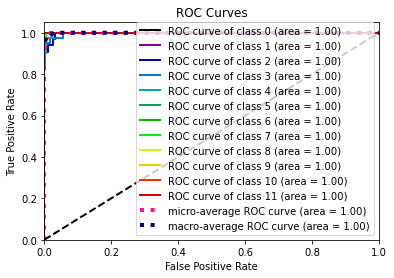

In [20]:
skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result)